# **Porftolio Drones**

### Inladen van de libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

### Inladen en splitsen van de data

In [2]:
def laad_afbeeldingen(map_pad):
    afbeeldingen = []
    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            breedte, hoogte = afbeelding.size
            helft_breedte = breedte // 2
            helft_hoogte = hoogte // 2
            
            kwadrant_1 = np.array(afbeelding.crop((0, 0, helft_breedte, helft_hoogte)))
            kwadrant_2 = np.array(afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte)))
            kwadrant_3 = np.array(afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte)))
            kwadrant_4 = np.array(afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte)))
            
            afbeeldingen.extend([kwadrant_1, kwadrant_2, kwadrant_3, kwadrant_4])

    return np.array(afbeeldingen, dtype=object)

def splits_en_opslaan_afbeeldingen(map_pad, nieuwe_map_pad):
    if not os.path.exists(nieuwe_map_pad):
        os.makedirs(nieuwe_map_pad)

    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            breedte, hoogte = afbeelding.size
            helft_breedte = breedte // 2
            helft_hoogte = hoogte // 2

            kwadrant_1 = afbeelding.crop((0, 0, helft_breedte, helft_hoogte))
            kwadrant_2 = afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte))
            kwadrant_3 = afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte))
            kwadrant_4 = afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte))

            # Opslaan van de de delen van de afbeelding
            kwadrant_1.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel1.jpg'))
            kwadrant_2.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel2.jpg'))
            kwadrant_3.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel3.jpg'))
            kwadrant_4.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel4.jpg'))

image_map_pad = 'images'
nieuwe_image_map_pad = 'image_kwadranten'
splits_en_opslaan_afbeeldingen(image_map_pad, nieuwe_image_map_pad)

mask_map_pad = 'masks'
nieuwe_mask_map_pad = 'mask_kwadranten'
splits_en_opslaan_afbeeldingen(mask_map_pad, nieuwe_mask_map_pad)

(4208,)

(4208,)

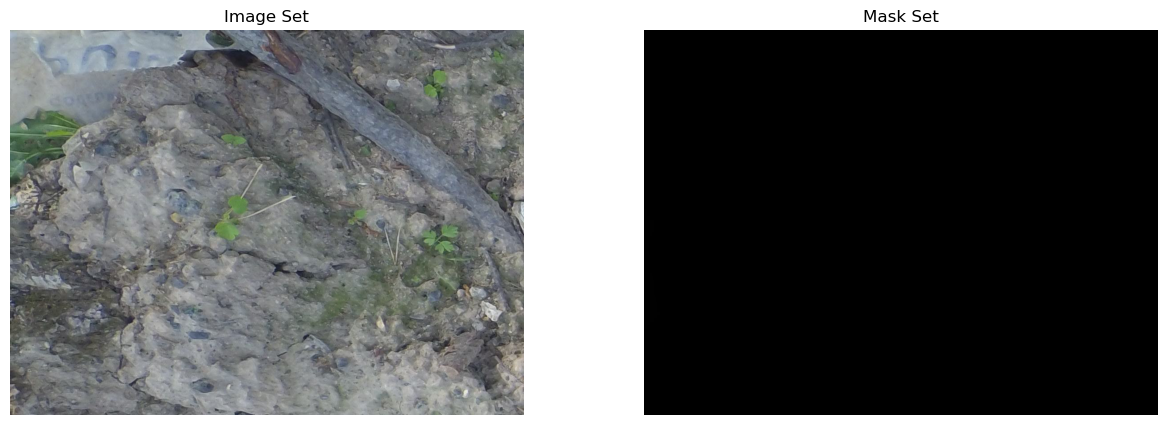

In [3]:
def toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen):
    train_afbeelding = train_afbeeldingen[np.random.randint(len(train_afbeeldingen))]
    test_afbeelding = test_afbeeldingen[np.random.randint(len(test_afbeeldingen))]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(train_afbeelding)
    axs[0].set_title("Image Set")
    axs[0].axis('off')
    axs[1].imshow(test_afbeelding)
    axs[1].set_title("Mask Set")
    axs[1].axis('off')
    plt.show()

image_map_pad = 'image_kwadranten'
image_afbeeldingen = laad_afbeeldingen(image_map_pad)

mask_map_pad = 'mask_kwadranten'
mask_afbeeldingen = laad_afbeeldingen(mask_map_pad)

display(image_afbeeldingen.shape, mask_afbeeldingen.shape)
toon_willekeurige_afbeeldingen_per_set(image_afbeeldingen, mask_afbeeldingen)

In [4]:
from fastai.vision.all import *

# Definiëren van de paden naar afbeeldingen en maskers
image_map_pad = 'image_kwadranten'
mask_map_pad = 'mask_kwadranten'

# Definiëren van de dataloaders
dls = SegmentationDataLoaders.from_label_func(
    path=image_map_pad,
    fnames=get_image_files(image_map_pad),
    label_func=lambda o: mask_map_pad + '/' + o.stem + o.suffix,  # Geen '_mask' suffix toegevoegd
    codes=np.array(['background', 'foreground']),
    batch_tfms=[*aug_transforms(size=(128, 128)), Normalize.from_stats(*imagenet_stats)]
)

# Definiëren van het leerling
learn = unet_learner(dls, resnet34)

# Trainen van het model
learn.fine_tune(10)

: 